In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import load_model

from trainer.constants import IM_SHAPE
from trainer.data import load_train_data, load_test_data, resize_image, augment
from trainer.models import UNet
from trainer.utils import mIOU, confusion

RAW_TRAIN_DIR = 'raw_data/train'

np.random.seed(0)

Take a look at some images

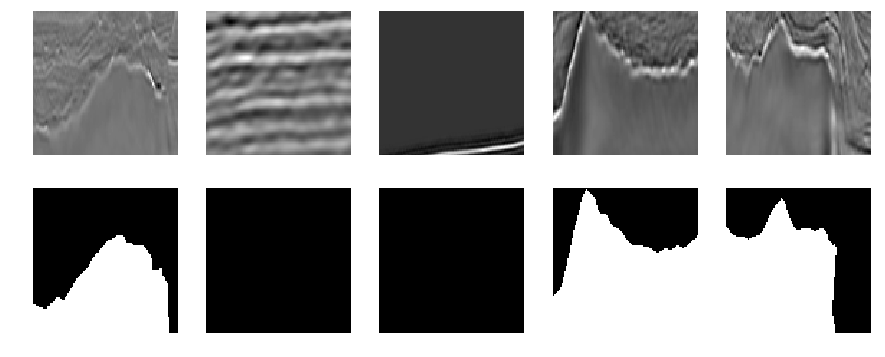

In [3]:
ids = ['1c20fc4477', '0d19f89dc9', '1a4ffa4415', '1bd1c8c771', '1c41821d13']
fig, axarr = plt.subplots(2, len(ids), figsize=(15, 6))
for i, id_ in enumerate(ids):
    img = mpimg.imread(os.path.join(RAW_TRAIN_DIR, 'images', id_ + '.png'))
    axarr[0, i].imshow(img)
    axarr[0, i].axis('off')
    mask = mpimg.imread(os.path.join(RAW_TRAIN_DIR, 'masks', id_ + '.png'))
    axarr[1, i].imshow(mask, cmap=plt.cm.gray)
    axarr[1, i].axis('off')

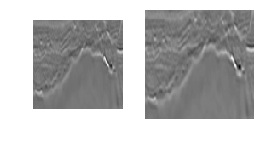

In [3]:
id_ = ids[0]
fig, axarr = plt.subplots(1, 2, figsize=(4, 2), gridspec_kw={'width_ratios': [101, 128]})  # Ratio of original to resized
img = mpimg.imread(os.path.join(RAW_TRAIN_DIR, 'images', id_ + '.png'))[:, :, 0]
axarr[0].imshow(img, cmap="gray")
axarr[0].axis('off')
resized_img = resize_image(img, IM_SHAPE[:-1])
axarr[1].imshow(resized_img, cmap="gray")
axarr[1].axis('off')
plt.show()

In [4]:
X_train, Y_train = load_train_data()
X_train, Y_train = augment(X_train, Y_train)

X_test = load_test_data()

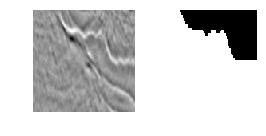

In [7]:
ix = 101
img = X_train[ix]
mask = Y_train[ix]
fig, axarr = plt.subplots(1, 2, figsize=(4, 2))
axarr[0].imshow(img.reshape(IM_SHAPE[:-1]), cmap=plt.cm.gray)
axarr[0].axis('off')
axarr[1].imshow(mask.reshape(IM_SHAPE[:-1]), cmap=plt.cm.gray)
axarr[1].axis('off')
plt.show()

In [9]:
model = UNet()
# model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mIOU])

In [25]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model_augmented.h5', verbose=1, save_best_only=True)
tblog = TensorBoard(
    log_dir='logs',
    histogram_freq=0,
    write_graph=True,
    embeddings_freq=0)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer, tblog])

Train on 7200 samples, validate on 800 samples
Epoch 1/30
7200/7200 [==============================] - 43s 6ms/step - loss: 0.4021 - mIOU: 0.4185 - val_loss: 0.2890 - val_mIOU: 0.4777

Epoch 00001: val_loss improved from inf to 0.28900, saving model to model_augmented.h5
Epoch 2/30
7200/7200 [==============================] - 42s 6ms/step - loss: 0.3031 - mIOU: 0.5215 - val_loss: 0.2313 - val_mIOU: 0.5540

Epoch 00002: val_loss improved from 0.28900 to 0.23132, saving model to model_augmented.h5
Epoch 3/30
7200/7200 [==============================] - 42s 6ms/step - loss: 0.2618 - mIOU: 0.5795 - val_loss: 0.2386 - val_mIOU: 0.6001

Epoch 00003: val_loss did not improve from 0.23132
Epoch 4/30
7200/7200 [==============================] - 42s 6ms/step - loss: 0.2361 - mIOU: 0.6164 - val_loss: 0.2200 - val_mIOU: 0.6317

Epoch 00004: val_loss improved from 0.23132 to 0.21997, saving model to model_augmented.h5
Epoch 5/30
7200/7200 [==============================] - 42s 6ms/step - loss: 0.21

In [3]:
model = load_model('model_augmented.h5', custom_objects={'mIOU': mIOU})

In [4]:
sep_ix = int(len(X_train) * 0.9)
X_train_only = X_train[:sep_ix]
Y_train_only = Y_train[:sep_ix]
Y_val = Y_train[sep_ix:]

Y_train_pred = model.predict(X_train[:sep_ix])
Y_val_pred = model.predict(X_train[sep_ix:])
Y_test_pred = model.predict(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


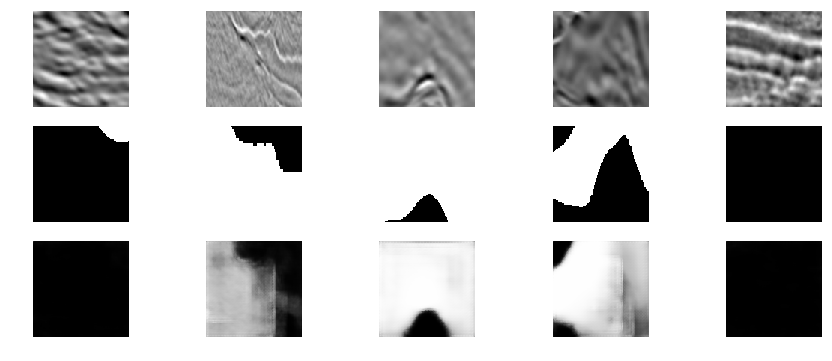

In [5]:
ixs = [1, 101, 345, 90, 1222]
fig, axarr = plt.subplots(3, len(ixs), figsize=(15, 6))
for i, ix in enumerate(ixs):
    inputs = X_train_only[ix].astype(np.float32)
    axarr[0, i].imshow(np.repeat(inputs, 3, 2))
    axarr[0, i].axis('off')
    actual = Y_train_only[ix].astype(np.float32)
    axarr[1, i].imshow(np.repeat(actual, 3, 2))
    axarr[1, i].axis('off')
    pred = Y_train_pred[ix]
    axarr[2, i].imshow(np.repeat(pred, 3, axis=2))
    axarr[2, i].axis('off')

In [6]:
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
train_scores = list()
for y_true, y_pred in tqdm(zip(Y_train_only, Y_train_pred), total=len(Y_train_only)):
    train_scores.append(custom_mIOU(y_true, y_pred))

C:\Users\garyg\Work\ml\kaggle\salt_id\trainer\utils.py:27: RuntimeWarning: invalid value encountered in long_scalars
  precisions.append(intersection.sum()/ union.sum())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

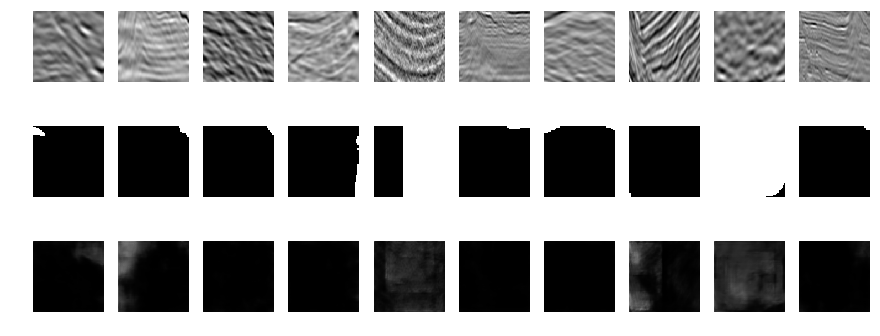

In [41]:
sorted_ix = np.argsort(train_scores)
ixs = sorted_ix[20:30]
fig, axarr = plt.subplots(3, len(ixs), figsize=(15, 6))
for i, ix in enumerate(ixs):
    inputs = X_train_only[ix].astype(np.float32)
    axarr[0, i].imshow(np.repeat(inputs, 3, 2))
    axarr[0, i].axis('off')
    actual = Y_train_only[ix].astype(np.float32)
    axarr[1, i].imshow(np.repeat(actual, 3, 2))
    axarr[1, i].axis('off')
    pred = Y_train_pred[ix]
    axarr[2, i].imshow(np.repeat(pred, 3, axis=2))
    axarr[2, i].axis('off')

It's pretty clear that false negative damages our score the most. I think a two-stage model where a relatively deeper model (e.g. YOLO or some variant) is applied first to get the approximate bounding box, and then we apply UNet to the resized bounding box region can help this, especially for examples with small positive areas. Hell, I might even just configure the model to use the bounding box as the end prediction if the bounding box is smaller than a threshold, to avoid over-scaling the image.

In [31]:
'''
Confusion analysis aborted for now, since I've decided that such complicated
computations cannot bring much more to the table. It's not hard to see the 
prevalence of false negatives.
'''
pass

# def threshold_sum(pred):
#     total = 0
#     for th in np.arange(0.5, 1, 0.05):
#         total += (pred > th).sum()
#     return np.mean(total)

# diff = 0
# stop = 1000
# fp_inv = 0
# fn_inv = 0
# for ix in sorted_ix[:stop]:
#     conf = confusion(Y_train_only[ix], Y_train_pred[ix])
#     tp = conf[0]
#     fp_inv += tp / (conf[2] + 0.01)
#     fn_inv += tp / (conf[3] + 0.01)
    
# print("How much does each type of error take away from mean IOU score (not accurate; need to get actual diff.)?")
# print("False positive:", fp_inv / stop)
# print("False negative:", fn_inv / stop)